In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

import optuna

from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("../data/Spaceship Titanic/train.csv")

In [3]:
df.drop(["PassengerId", "Name"], axis=1, inplace=True)

In [4]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [5]:
len(df["Cabin"].unique())

6561

In [6]:
df["Cabin"] = df["Cabin"].fillna(0)
df["Cabin"] = df["Cabin"].str[0]

In [7]:
len(df["Cabin"].unique())

9

In [8]:
df.isna().mean()

HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Transported     0.000000
dtype: float64

In [9]:
df.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
dtype: object

In [10]:
df["CryoSleep"] = df["CryoSleep"].astype("boolean")
df["VIP"] = df["VIP"].astype("boolean")

In [11]:
cat_labels = [c for c in df if not pd.api.types.is_numeric_dtype(df[c])]
num_labels = [c for c in df if pd.api.types.is_numeric_dtype(df[c]) and c != "Transported"]

In [12]:
cat_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

In [16]:
num_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

In [17]:
preprocessor = ColumnTransformer([
    ("cat_imputer", cat_imputer, cat_labels),
    ("num_imputer", num_imputer, num_labels)
], remainder="passthrough")

In [18]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", CatBoostClassifier(verbose=False))
])

In [13]:
X = df.drop("Transported", axis=1)
y = df["Transported"]

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [21]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'Cabin',
                                                   'Destination']),
                                                 ('num_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['CryoSleep', 'Age', 'VIP',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000237BEE8BA30>)])

In [22]:
model.score(X_valid, y_valid)

0.8017638036809815

In [23]:
grid_params = {
    "preprocessor__cat_imputer__imputer__strategy": ["constant", "most_frequent"],
    "preprocessor__num_imputer__imputer__strategy": ["mean", "median"]
}

In [24]:
gs_model = GridSearchCV(model, grid_params, cv=5, n_jobs=-1, scoring="accuracy")

In [25]:
gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_imputer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['HomePlanet',
                                                                          'Cabin',
                                                                          'Destination']),
                                                                        ('num_imputer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          Simple...an'))]),
                                                                         ['CryoSleep',
                                                                          'Age',
                                                                          'VIP',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck'])])),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x00000237BEE8BA30>)]),
             n_jobs=-1,
             param_grid={'preprocessor__cat_imputer__imputer__strategy': ['constant',
                                                                          'most_frequent'],
                         'preprocessor__num_imputer__imputer__strategy': ['mean',
                                                                          'median']},
             scoring='accuracy')

In [26]:
gs_model.score(X_valid, y_valid)

0.7975460122699386

Didn't make a difference. Lets try Optuna

In [27]:
gs_model.best_params_

{'preprocessor__cat_imputer__imputer__strategy': 'most_frequent',
 'preprocessor__num_imputer__imputer__strategy': 'mean'}

In [15]:
num_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

In [16]:
preprocessor = ColumnTransformer([
    ("cat_imputer", cat_imputer, cat_labels),
    ("num_imputer", num_imputer, num_labels)
], remainder="passthrough")

In [17]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_valid_encoded = preprocessor.transform(X_valid)

In [19]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 2, 8),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 8)
    }

    model = CatBoostClassifier(**params, verbose=False, early_stopping_rounds=100)
    model.fit(X_train_encoded, y_train)
    y_preds = model.predict(X_valid_encoded)
    return roc_auc_score(y_valid, y_preds)

In [20]:
study = optuna.create_study(direction="maximize")

[I 2024-07-17 09:22:11,424] A new study created in memory with name: no-name-f3a42742-ea89-4ea2-be73-462399a4de2e


In [29]:
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-07-17 09:50:07,374] Trial 106 finished with value: 0.8109172915348111 and parameters: {'iterations': 437, 'learning_rate': 0.0749059600814371, 'depth': 2, 'l2_leaf_reg': 5}. Best is trial 106 with value: 0.8109172915348111.
[I 2024-07-17 09:50:07,405] Trial 108 finished with value: 0.8089732790931314 and parameters: {'iterations': 436, 'learning_rate': 0.07353343406627535, 'depth': 2, 'l2_leaf_reg': 5}. Best is trial 106 with value: 0.8109172915348111.
[I 2024-07-17 09:50:07,421] Trial 105 finished with value: 0.8109702298463847 and parameters: {'iterations': 442, 'learning_rate': 0.07452622701131745, 'depth': 2, 'l2_leaf_reg': 5}. Best is trial 105 with value: 0.8109702298463847.
[I 2024-07-17 09:50:07,436] Trial 107 finished with value: 0.8082803754149775 and parameters: {'iterations': 466, 'learning_rate': 0.07518355580806055, 'depth': 2, 'l2_leaf_reg': 5}. Best is trial 105 with value: 0.8109702298463847.
[I 2024-07-17 09:50:08,501] Trial 112 finished with value: 0.80748159

In [30]:
study.best_params

{'iterations': 571,
 'learning_rate': 0.06212412875671592,
 'depth': 2,
 'l2_leaf_reg': 5}

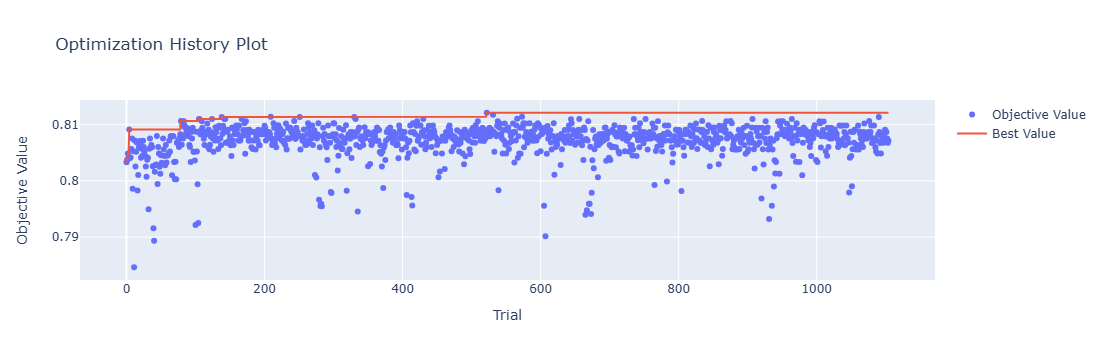

In [31]:
optuna.visualization.plot_optimization_history(study)

In [32]:
model = CatBoostClassifier(iterations=571, learning_rate=0.06212412875671592, depth=2, l2_leaf_reg=5, verbose=False)

In [33]:
model.fit(X_train_encoded, y_train, plot=True, eval_set=(X_valid_encoded, y_valid));

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
model.score(X_valid_encoded, y_valid)

0.8117331288343558